In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

In [63]:
class LeNET(nn.Module):
  def __init__(self, in_channels=1,out_channels=10):
    super(LeNET, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.relu = nn.ReLU()
    self.pool = nn.AvgPool2d(kernel_size = (2,2), stride=(2,2))
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 6, kernel_size = (5,5), stride = (1,1), padding = (2,2))
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels =120, kernel_size = (5,5), stride = (1,1), padding = (0,0))
    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84,out_channels)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(x)
    x = self.relu(self.conv2(x))
    x = self.pool(x)
    x = self.relu(self.conv3(x))# num_examples x 120 x 1 x 1 -- > num_examples x 120
    x = x.reshape(x.shape[0], -1)
    x = self.relu(self.linear1(x))
    x = self.linear2(x)
    return x 

In [52]:
x = torch.randn(64, 1, 28, 28)
model = LeNET()
print(model(x).shape)

torch.Size([64, 10])


In [ ]:
#Setup train data
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.MNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

Image Shape: torch.Size([1, 28, 28])


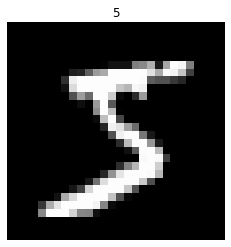

In [ ]:
#Visualising the data
#understanding input and output shape
image, label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label);
plt.axis(False);

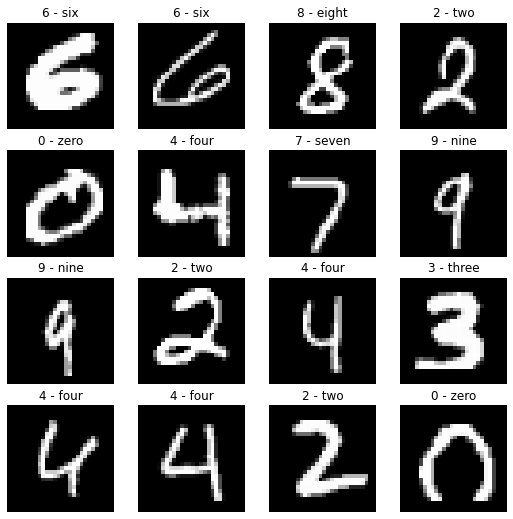

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_LENET_0 = LeNET().to(device)

In [55]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_0.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [56]:
#Functionizing training and evaluation/testing loops
#We create a function for training loop - train_step()
#testing loop - test_step()

def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  train_loss, train_acc = 0, 0
  #Put model in training mode
  model.train()
  #Add a loop through the training batches 
  for batch, (X,y) in enumerate(data_loader):#Enumerate helps keeping track of batches
    #Put data on target device
    X,y = X.to(device), y.to(device)
    #forward pass
    y_pred = model(X)
    #loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    #Optimizer zero grad
    optimizer.zero_grad()
    #Loss backward
    loss.backward()
    #Step
    optimizer.step()

  #Adjust the training loss so that it gives us the loss per epoch an not per batch
  #Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")

In [57]:
def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  test_loss, test_acc = 0, 0
  #Put model in training mode
  model.eval()
  #Add a loop through the training batches 
  with torch.inference_mode():
    for X,y in data_loader:#Enumerate helps keeping track of batches
      #Put data on target device
      X,y = X.to(device), y.to(device)
      #forward pass
      test_pred = model(X)
      #loss and accuracy
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    #Adjust the training loss so that it gives us the loss per epoch an not per batch
    #Divide total train loss by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [ ]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_0, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_0,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 1.12619, Train acc: 60.31%


  2%|▏         | 1/50 [00:19<15:31, 19.00s/it]

Test Loss: 0.21287, Test acc: 93.76%
Epoch: 1 ----
Train Loss: 0.18803, Train acc: 94.10%


  4%|▍         | 2/50 [00:29<11:03, 13.82s/it]

Test Loss: 0.11595, Test acc: 96.24%
Epoch: 2 ----
Train Loss: 0.11542, Train acc: 96.41%


  6%|▌         | 3/50 [00:39<09:28, 12.10s/it]

Test Loss: 0.08648, Test acc: 97.35%
Epoch: 3 ----
Train Loss: 0.08723, Train acc: 97.28%


  8%|▊         | 4/50 [00:49<08:40, 11.32s/it]

Test Loss: 0.07450, Test acc: 97.67%
Epoch: 4 ----
Train Loss: 0.06952, Train acc: 97.82%


 10%|█         | 5/50 [01:00<08:25, 11.24s/it]

Test Loss: 0.06114, Test acc: 98.00%
Epoch: 5 ----
Train Loss: 0.05813, Train acc: 98.12%


 12%|█▏        | 6/50 [01:10<07:57, 10.85s/it]

Test Loss: 0.07306, Test acc: 97.68%
Epoch: 6 ----
Train Loss: 0.05078, Train acc: 98.44%


 14%|█▍        | 7/50 [01:20<07:37, 10.63s/it]

Test Loss: 0.05278, Test acc: 98.17%
Epoch: 7 ----
Train Loss: 0.04528, Train acc: 98.52%


 16%|█▌        | 8/50 [01:32<07:39, 10.94s/it]

Test Loss: 0.04630, Test acc: 98.55%
Epoch: 8 ----
Train Loss: 0.04011, Train acc: 98.75%


 18%|█▊        | 9/50 [01:42<07:14, 10.59s/it]

Test Loss: 0.04837, Test acc: 98.34%
Epoch: 9 ----
Train Loss: 0.03651, Train acc: 98.78%


 20%|██        | 10/50 [01:51<06:53, 10.34s/it]

Test Loss: 0.04403, Test acc: 98.53%
Epoch: 10 ----
Train Loss: 0.03209, Train acc: 98.97%


 22%|██▏       | 11/50 [02:01<06:35, 10.13s/it]

Test Loss: 0.05035, Test acc: 98.44%
Epoch: 11 ----
Train Loss: 0.02998, Train acc: 99.01%


 24%|██▍       | 12/50 [02:11<06:20, 10.02s/it]

Test Loss: 0.05137, Test acc: 98.30%
Epoch: 12 ----
Train Loss: 0.02636, Train acc: 99.17%


 26%|██▌       | 13/50 [02:20<06:06,  9.90s/it]

Test Loss: 0.04687, Test acc: 98.59%
Epoch: 13 ----
Train Loss: 0.02419, Train acc: 99.18%


 28%|██▊       | 14/50 [02:30<05:51,  9.78s/it]

Test Loss: 0.04454, Test acc: 98.61%
Epoch: 14 ----
Train Loss: 0.02273, Train acc: 99.24%


 30%|███       | 15/50 [02:40<05:39,  9.71s/it]

Test Loss: 0.04045, Test acc: 98.85%
Epoch: 15 ----
Train Loss: 0.01989, Train acc: 99.33%


 32%|███▏      | 16/50 [02:49<05:29,  9.68s/it]

Test Loss: 0.04303, Test acc: 98.65%
Epoch: 16 ----
Train Loss: 0.01878, Train acc: 99.38%


 34%|███▍      | 17/50 [02:59<05:18,  9.64s/it]

Test Loss: 0.04779, Test acc: 98.50%
Epoch: 17 ----
Train Loss: 0.01725, Train acc: 99.44%


 36%|███▌      | 18/50 [03:08<05:08,  9.65s/it]

Test Loss: 0.04166, Test acc: 98.71%
Epoch: 18 ----
Train Loss: 0.01529, Train acc: 99.49%


 38%|███▊      | 19/50 [03:18<04:58,  9.62s/it]

Test Loss: 0.03911, Test acc: 98.79%
Epoch: 19 ----
Train Loss: 0.01431, Train acc: 99.52%


 40%|████      | 20/50 [03:28<04:48,  9.63s/it]

Test Loss: 0.04726, Test acc: 98.60%
Epoch: 20 ----
Train Loss: 0.01296, Train acc: 99.58%


 42%|████▏     | 21/50 [03:37<04:38,  9.59s/it]

Test Loss: 0.03908, Test acc: 98.73%
Epoch: 21 ----
Train Loss: 0.01217, Train acc: 99.61%


 44%|████▍     | 22/50 [03:47<04:28,  9.59s/it]

Test Loss: 0.04268, Test acc: 98.74%
Epoch: 22 ----
Train Loss: 0.01051, Train acc: 99.67%


 46%|████▌     | 23/50 [03:56<04:18,  9.58s/it]

Test Loss: 0.04686, Test acc: 98.72%
Epoch: 23 ----
Train Loss: 0.00894, Train acc: 99.72%


 48%|████▊     | 24/50 [04:06<04:08,  9.57s/it]

Test Loss: 0.04028, Test acc: 98.88%
Epoch: 24 ----
Train Loss: 0.00993, Train acc: 99.69%


 50%|█████     | 25/50 [04:15<03:59,  9.59s/it]

Test Loss: 0.04796, Test acc: 98.66%
Epoch: 25 ----
Train Loss: 0.00834, Train acc: 99.73%


 52%|█████▏    | 26/50 [04:25<03:50,  9.62s/it]

Test Loss: 0.05223, Test acc: 98.63%
Epoch: 26 ----
Train Loss: 0.00871, Train acc: 99.71%


 54%|█████▍    | 27/50 [04:35<03:40,  9.60s/it]

Test Loss: 0.04915, Test acc: 98.81%
Epoch: 27 ----
Train Loss: 0.00790, Train acc: 99.75%


 56%|█████▌    | 28/50 [04:44<03:31,  9.59s/it]

Test Loss: 0.05439, Test acc: 98.65%
Epoch: 28 ----
Train Loss: 0.00669, Train acc: 99.78%


 58%|█████▊    | 29/50 [04:54<03:21,  9.59s/it]

Test Loss: 0.04807, Test acc: 98.70%
Epoch: 29 ----
Train Loss: 0.00575, Train acc: 99.84%


 60%|██████    | 30/50 [05:03<03:11,  9.59s/it]

Test Loss: 0.04763, Test acc: 98.86%
Epoch: 30 ----
Train Loss: 0.00596, Train acc: 99.82%


 62%|██████▏   | 31/50 [05:13<03:01,  9.57s/it]

Test Loss: 0.05060, Test acc: 98.78%
Epoch: 31 ----
Train Loss: 0.00578, Train acc: 99.81%


 64%|██████▍   | 32/50 [05:22<02:52,  9.57s/it]

Test Loss: 0.04668, Test acc: 98.83%
Epoch: 32 ----
Train Loss: 0.00530, Train acc: 99.84%


 66%|██████▌   | 33/50 [05:32<02:43,  9.59s/it]

Test Loss: 0.04741, Test acc: 98.85%
Epoch: 33 ----
Train Loss: 0.00425, Train acc: 99.87%


 68%|██████▊   | 34/50 [05:43<02:40, 10.01s/it]

Test Loss: 0.04994, Test acc: 98.88%
Epoch: 34 ----
Train Loss: 0.00292, Train acc: 99.92%


 70%|███████   | 35/50 [05:53<02:29,  9.97s/it]

Test Loss: 0.05134, Test acc: 98.74%
Epoch: 35 ----
Train Loss: 0.00374, Train acc: 99.89%


 72%|███████▏  | 36/50 [06:03<02:18,  9.91s/it]

Test Loss: 0.07541, Test acc: 98.34%
Epoch: 36 ----
Train Loss: 0.00597, Train acc: 99.81%


 74%|███████▍  | 37/50 [06:12<02:07,  9.83s/it]

Test Loss: 0.05602, Test acc: 98.58%
Epoch: 37 ----
Train Loss: 0.00383, Train acc: 99.88%


 76%|███████▌  | 38/50 [06:22<01:57,  9.80s/it]

Test Loss: 0.05364, Test acc: 98.70%
Epoch: 38 ----
Train Loss: 0.00350, Train acc: 99.90%


 78%|███████▊  | 39/50 [06:32<01:47,  9.80s/it]

Test Loss: 0.04793, Test acc: 98.86%
Epoch: 39 ----
Train Loss: 0.00404, Train acc: 99.88%


 80%|████████  | 40/50 [06:42<01:37,  9.76s/it]

Test Loss: 0.05236, Test acc: 98.83%
Epoch: 40 ----
Train Loss: 0.00529, Train acc: 99.82%


 82%|████████▏ | 41/50 [06:51<01:27,  9.75s/it]

Test Loss: 0.05143, Test acc: 98.85%
Epoch: 41 ----
Train Loss: 0.00308, Train acc: 99.90%


 84%|████████▍ | 42/50 [07:01<01:18,  9.79s/it]

Test Loss: 0.05923, Test acc: 98.67%
Epoch: 42 ----
Train Loss: 0.00416, Train acc: 99.88%


 86%|████████▌ | 43/50 [07:11<01:08,  9.81s/it]

Test Loss: 0.05526, Test acc: 98.69%
Epoch: 43 ----
Train Loss: 0.00448, Train acc: 99.89%


 88%|████████▊ | 44/50 [07:21<00:58,  9.79s/it]

Test Loss: 0.05570, Test acc: 98.76%
Epoch: 44 ----
Train Loss: 0.00422, Train acc: 99.86%


 90%|█████████ | 45/50 [07:30<00:48,  9.75s/it]

Test Loss: 0.04976, Test acc: 98.87%
Epoch: 45 ----
Train Loss: 0.00406, Train acc: 99.86%


 92%|█████████▏| 46/50 [07:40<00:38,  9.73s/it]

Test Loss: 0.05082, Test acc: 98.91%
Epoch: 46 ----
Train Loss: 0.00185, Train acc: 99.95%


 94%|█████████▍| 47/50 [07:50<00:29,  9.74s/it]

Test Loss: 0.05035, Test acc: 98.81%
Epoch: 47 ----
Train Loss: 0.00081, Train acc: 99.98%


 96%|█████████▌| 48/50 [08:00<00:19,  9.74s/it]

Test Loss: 0.04839, Test acc: 98.91%
Epoch: 48 ----
Train Loss: 0.00109, Train acc: 99.97%


 98%|█████████▊| 49/50 [08:10<00:09,  9.78s/it]

Test Loss: 0.04688, Test acc: 99.02%
Epoch: 49 ----
Train Loss: 0.00047, Train acc: 99.99%


100%|██████████| 50/50 [08:19<00:00,  9.99s/it]

Test Loss: 0.04595, Test acc: 99.02%
Train time on cuda : 499.714 seconds


In [ ]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "01_LENET_MNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [ ]:
#Saving the model
torch.save(obj=model_LENET_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/01_LENET_MNIST.pth


In [ ]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_MNIST = LeNET().to(device)
model_LENET_MNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss,acc = 0, 0
  #Returns a dictionary containing the results of the model predicting on data_loader
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      #Make predictions
      y_pred = model(X)

      #Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    #Scale the loss and acc to find the average loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

In [ ]:
#Get model results
model_LENET_MNIST_results = eval_model(
    model=model_LENET_MNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_MNIST_results

100%|██████████| 313/313 [00:01<00:00, 296.92it/s]


{'model_name': 'LeNET',
 'model_loss': 0.045953311026096344,
 'model_acc': 99.02156549520767}

Fashion MNIST


In [ ]:
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.ToTensor())

test_data = datasets.FashionMNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

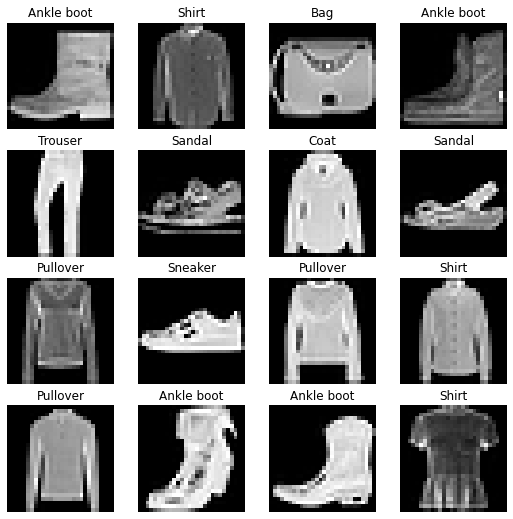

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_LENET_1 = LeNET().to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_1.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_1, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_1,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 1.10633, Train acc: 58.18%


  2%|▏         | 1/50 [00:09<07:58,  9.77s/it]

Test Loss: 0.69412, Test acc: 73.65%
Epoch: 1 ----
Train Loss: 0.54701, Train acc: 79.18%


  4%|▍         | 2/50 [00:19<07:43,  9.66s/it]

Test Loss: 0.51864, Test acc: 80.12%
Epoch: 2 ----
Train Loss: 0.46168, Train acc: 82.88%


  6%|▌         | 3/50 [00:29<07:35,  9.69s/it]

Test Loss: 0.44667, Test acc: 83.27%
Epoch: 3 ----
Train Loss: 0.41747, Train acc: 84.44%


  8%|▊         | 4/50 [00:38<07:25,  9.68s/it]

Test Loss: 0.42351, Test acc: 84.31%
Epoch: 4 ----
Train Loss: 0.38558, Train acc: 85.69%


 10%|█         | 5/50 [00:48<07:14,  9.66s/it]

Test Loss: 0.41016, Test acc: 85.11%
Epoch: 5 ----
Train Loss: 0.36168, Train acc: 86.64%


 12%|█▏        | 6/50 [00:58<07:04,  9.66s/it]

Test Loss: 0.39991, Test acc: 85.50%
Epoch: 6 ----
Train Loss: 0.34378, Train acc: 87.20%


 14%|█▍        | 7/50 [01:07<06:56,  9.70s/it]

Test Loss: 0.36873, Test acc: 86.64%
Epoch: 7 ----
Train Loss: 0.32998, Train acc: 87.72%


 16%|█▌        | 8/50 [01:17<06:47,  9.71s/it]

Test Loss: 0.35575, Test acc: 87.07%
Epoch: 8 ----
Train Loss: 0.31821, Train acc: 88.16%


 18%|█▊        | 9/50 [01:28<06:53, 10.09s/it]

Test Loss: 0.35246, Test acc: 87.22%
Epoch: 9 ----
Train Loss: 0.30719, Train acc: 88.58%


 20%|██        | 10/50 [01:38<06:42, 10.05s/it]

Test Loss: 0.34323, Test acc: 87.14%
Epoch: 10 ----
Train Loss: 0.29868, Train acc: 88.84%


 22%|██▏       | 11/50 [01:47<06:25,  9.89s/it]

Test Loss: 0.34122, Test acc: 87.50%
Epoch: 11 ----
Train Loss: 0.28941, Train acc: 89.10%


 24%|██▍       | 12/50 [01:57<06:13,  9.82s/it]

Test Loss: 0.34024, Test acc: 87.98%
Epoch: 12 ----
Train Loss: 0.28127, Train acc: 89.48%


 26%|██▌       | 13/50 [02:07<06:01,  9.77s/it]

Test Loss: 0.32356, Test acc: 88.35%
Epoch: 13 ----
Train Loss: 0.27471, Train acc: 89.74%


 28%|██▊       | 14/50 [02:16<05:50,  9.74s/it]

Test Loss: 0.32898, Test acc: 88.48%
Epoch: 14 ----
Train Loss: 0.26778, Train acc: 89.88%


 30%|███       | 15/50 [02:26<05:40,  9.72s/it]

Test Loss: 0.32877, Test acc: 88.01%
Epoch: 15 ----
Train Loss: 0.26183, Train acc: 90.17%


 32%|███▏      | 16/50 [02:36<05:30,  9.71s/it]

Test Loss: 0.32758, Test acc: 88.42%
Epoch: 16 ----
Train Loss: 0.25542, Train acc: 90.43%


 34%|███▍      | 17/50 [02:46<05:20,  9.70s/it]

Test Loss: 0.33534, Test acc: 88.29%
Epoch: 17 ----
Train Loss: 0.24983, Train acc: 90.62%


 36%|███▌      | 18/50 [02:55<05:09,  9.68s/it]

Test Loss: 0.32981, Test acc: 88.27%
Epoch: 18 ----
Train Loss: 0.24433, Train acc: 90.78%


 38%|███▊      | 19/50 [03:05<04:59,  9.67s/it]

Test Loss: 0.31634, Test acc: 88.53%
Epoch: 19 ----
Train Loss: 0.23824, Train acc: 91.00%


 40%|████      | 20/50 [03:15<04:51,  9.72s/it]

Test Loss: 0.32398, Test acc: 88.29%
Epoch: 20 ----
Train Loss: 0.23277, Train acc: 91.27%


 42%|████▏     | 21/50 [03:24<04:41,  9.72s/it]

Test Loss: 0.31404, Test acc: 88.84%
Epoch: 21 ----
Train Loss: 0.22893, Train acc: 91.34%


 44%|████▍     | 22/50 [03:34<04:31,  9.71s/it]

Test Loss: 0.30201, Test acc: 89.60%
Epoch: 22 ----
Train Loss: 0.22464, Train acc: 91.56%


 46%|████▌     | 23/50 [03:44<04:21,  9.67s/it]

Test Loss: 0.29831, Test acc: 89.30%
Epoch: 23 ----
Train Loss: 0.21948, Train acc: 91.64%


 48%|████▊     | 24/50 [03:53<04:10,  9.64s/it]

Test Loss: 0.30198, Test acc: 89.28%
Epoch: 24 ----
Train Loss: 0.21478, Train acc: 91.90%


 50%|█████     | 25/50 [04:03<04:00,  9.62s/it]

Test Loss: 0.30868, Test acc: 89.17%
Epoch: 25 ----
Train Loss: 0.20961, Train acc: 92.07%


 52%|█████▏    | 26/50 [04:12<03:51,  9.63s/it]

Test Loss: 0.30369, Test acc: 89.27%
Epoch: 26 ----
Train Loss: 0.20639, Train acc: 92.23%


 54%|█████▍    | 27/50 [04:22<03:41,  9.63s/it]

Test Loss: 0.29695, Test acc: 89.47%
Epoch: 27 ----
Train Loss: 0.20059, Train acc: 92.46%


 56%|█████▌    | 28/50 [04:32<03:32,  9.65s/it]

Test Loss: 0.29873, Test acc: 89.47%
Epoch: 28 ----
Train Loss: 0.19769, Train acc: 92.59%


 58%|█████▊    | 29/50 [04:41<03:23,  9.67s/it]

Test Loss: 0.30523, Test acc: 89.64%
Epoch: 29 ----
Train Loss: 0.19322, Train acc: 92.60%


 60%|██████    | 30/50 [04:51<03:13,  9.68s/it]

Test Loss: 0.31001, Test acc: 89.18%
Epoch: 30 ----
Train Loss: 0.19051, Train acc: 92.80%


 62%|██████▏   | 31/50 [05:01<03:04,  9.69s/it]

Test Loss: 0.31446, Test acc: 89.47%
Epoch: 31 ----
Train Loss: 0.18577, Train acc: 93.03%


 64%|██████▍   | 32/50 [05:10<02:54,  9.67s/it]

Test Loss: 0.30087, Test acc: 89.60%
Epoch: 32 ----
Train Loss: 0.18094, Train acc: 93.01%


 66%|██████▌   | 33/50 [05:20<02:44,  9.66s/it]

Test Loss: 0.31534, Test acc: 89.41%
Epoch: 33 ----
Train Loss: 0.17808, Train acc: 93.28%


 68%|██████▊   | 34/50 [05:30<02:34,  9.68s/it]

Test Loss: 0.32646, Test acc: 89.71%
Epoch: 34 ----
Train Loss: 0.17420, Train acc: 93.37%


 70%|███████   | 35/50 [05:41<02:32, 10.14s/it]

Test Loss: 0.31763, Test acc: 89.77%
Epoch: 35 ----
Train Loss: 0.17100, Train acc: 93.52%


 72%|███████▏  | 36/50 [05:51<02:19,  9.98s/it]

Test Loss: 0.30077, Test acc: 89.86%
Epoch: 36 ----
Train Loss: 0.16803, Train acc: 93.62%


 74%|███████▍  | 37/50 [06:00<02:08,  9.88s/it]

Test Loss: 0.31680, Test acc: 89.69%
Epoch: 37 ----
Train Loss: 0.16274, Train acc: 93.87%


 76%|███████▌  | 38/50 [06:10<01:57,  9.79s/it]

Test Loss: 0.31589, Test acc: 89.64%
Epoch: 38 ----
Train Loss: 0.15938, Train acc: 93.89%


 78%|███████▊  | 39/50 [06:19<01:47,  9.73s/it]

Test Loss: 0.31955, Test acc: 89.56%
Epoch: 39 ----
Train Loss: 0.15805, Train acc: 93.98%


 80%|████████  | 40/50 [06:29<01:37,  9.72s/it]

Test Loss: 0.31153, Test acc: 90.06%
Epoch: 40 ----
Train Loss: 0.15364, Train acc: 94.14%


 82%|████████▏ | 41/50 [06:39<01:27,  9.70s/it]

Test Loss: 0.33893, Test acc: 89.56%
Epoch: 41 ----
Train Loss: 0.14978, Train acc: 94.30%


 84%|████████▍ | 42/50 [06:49<01:19,  9.97s/it]

Test Loss: 0.31522, Test acc: 89.72%
Epoch: 42 ----
Train Loss: 0.14611, Train acc: 94.48%


 86%|████████▌ | 43/50 [07:00<01:11, 10.19s/it]

Test Loss: 0.31185, Test acc: 90.28%
Epoch: 43 ----
Train Loss: 0.14256, Train acc: 94.61%


 88%|████████▊ | 44/50 [07:11<01:01, 10.26s/it]

Test Loss: 0.32540, Test acc: 89.79%
Epoch: 44 ----
Train Loss: 0.14074, Train acc: 94.67%


 90%|█████████ | 45/50 [07:21<00:51, 10.34s/it]

Test Loss: 0.32112, Test acc: 90.28%
Epoch: 45 ----
Train Loss: 0.13703, Train acc: 94.79%


 92%|█████████▏| 46/50 [07:31<00:41, 10.35s/it]

Test Loss: 0.31850, Test acc: 89.97%
Epoch: 46 ----
Train Loss: 0.13379, Train acc: 94.97%


 94%|█████████▍| 47/50 [07:42<00:31, 10.38s/it]

Test Loss: 0.33316, Test acc: 90.12%
Epoch: 47 ----
Train Loss: 0.13109, Train acc: 95.09%


 96%|█████████▌| 48/50 [07:52<00:20, 10.37s/it]

Test Loss: 0.35798, Test acc: 89.17%
Epoch: 48 ----
Train Loss: 0.12912, Train acc: 95.13%


 98%|█████████▊| 49/50 [08:03<00:10, 10.35s/it]

Test Loss: 0.34430, Test acc: 90.12%
Epoch: 49 ----
Train Loss: 0.12607, Train acc: 95.27%


100%|██████████| 50/50 [08:13<00:00,  9.87s/it]

Test Loss: 0.36447, Test acc: 89.44%
Train time on cuda : 493.455 seconds


In [ ]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "02_LENET_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [ ]:
#Saving the model
torch.save(obj=model_LENET_1.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/02_LENET_FashionMNIST.pth


In [ ]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_FashionMNIST = LeNET().to(device)
model_LENET_FashionMNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
#Get model results
model_LENET_FashionMNIST_results = eval_model(
    model=model_LENET_FashionMNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_FashionMNIST_results

100%|██████████| 313/313 [00:01<00:00, 274.11it/s]


{'model_name': 'LeNET',
 'model_loss': 0.36447450518608093,
 'model_acc': 89.43690095846645}

CIFAR 10


In [ ]:
train_data = datasets.CIFAR10(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR10(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9},
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

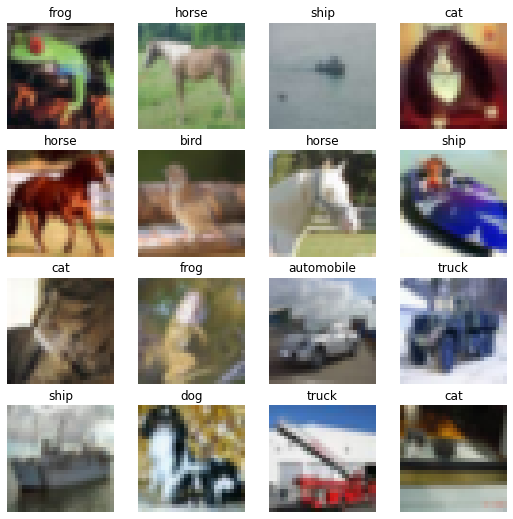

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model_LENET_2 = LeNET(in_channels=3).to(device)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_2.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_2, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_2,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 2.30289, Train acc: 9.90%


  2%|▏         | 1/50 [00:14<11:28, 14.05s/it]

Test Loss: 2.30128, Test acc: 13.08%
Epoch: 1 ----
Train Loss: 2.07985, Train acc: 22.95%


  4%|▍         | 2/50 [00:27<11:04, 13.85s/it]

Test Loss: 1.86459, Test acc: 32.93%
Epoch: 2 ----
Train Loss: 1.76799, Train acc: 36.64%


  6%|▌         | 3/50 [00:41<10:46, 13.76s/it]

Test Loss: 1.64730, Test acc: 40.10%
Epoch: 3 ----
Train Loss: 1.60064, Train acc: 42.59%


  8%|▊         | 4/50 [00:54<10:29, 13.68s/it]

Test Loss: 1.61376, Test acc: 41.63%
Epoch: 4 ----
Train Loss: 1.50163, Train acc: 46.03%


 10%|█         | 5/50 [01:08<10:17, 13.72s/it]

Test Loss: 1.59305, Test acc: 44.31%
Epoch: 5 ----
Train Loss: 1.43291, Train acc: 48.93%


 12%|█▏        | 6/50 [01:22<10:00, 13.64s/it]

Test Loss: 1.42319, Test acc: 49.05%
Epoch: 6 ----
Train Loss: 1.36966, Train acc: 51.47%


 14%|█▍        | 7/50 [01:37<10:14, 14.30s/it]

Test Loss: 1.40964, Test acc: 49.79%
Epoch: 7 ----
Train Loss: 1.31542, Train acc: 53.15%


 16%|█▌        | 8/50 [01:51<09:51, 14.08s/it]

Test Loss: 1.37561, Test acc: 50.38%
Epoch: 8 ----
Train Loss: 1.26847, Train acc: 54.93%


 18%|█▊        | 9/50 [02:05<09:30, 13.91s/it]

Test Loss: 1.36036, Test acc: 51.71%
Epoch: 9 ----
Train Loss: 1.22497, Train acc: 56.29%


 20%|██        | 10/50 [02:19<09:17, 13.95s/it]

Test Loss: 1.25308, Test acc: 55.93%
Epoch: 10 ----
Train Loss: 1.18546, Train acc: 57.83%


 22%|██▏       | 11/50 [02:33<09:05, 13.98s/it]

Test Loss: 1.24539, Test acc: 55.65%
Epoch: 11 ----
Train Loss: 1.14645, Train acc: 59.20%


 24%|██▍       | 12/50 [02:46<08:49, 13.93s/it]

Test Loss: 1.24206, Test acc: 56.45%
Epoch: 12 ----
Train Loss: 1.11438, Train acc: 60.30%


 26%|██▌       | 13/50 [02:59<08:24, 13.62s/it]

Test Loss: 1.23047, Test acc: 56.98%
Epoch: 13 ----
Train Loss: 1.08120, Train acc: 61.54%


 28%|██▊       | 14/50 [03:12<08:03, 13.42s/it]

Test Loss: 1.44082, Test acc: 51.31%
Epoch: 14 ----
Train Loss: 1.04911, Train acc: 62.75%


 30%|███       | 15/50 [03:25<07:43, 13.23s/it]

Test Loss: 1.20183, Test acc: 58.28%
Epoch: 15 ----
Train Loss: 1.01943, Train acc: 63.84%


 32%|███▏      | 16/50 [03:38<07:29, 13.21s/it]

Test Loss: 1.18978, Test acc: 58.37%
Epoch: 16 ----
Train Loss: 0.99435, Train acc: 64.58%


 34%|███▍      | 17/50 [03:53<07:26, 13.52s/it]

Test Loss: 1.18733, Test acc: 58.38%
Epoch: 17 ----
Train Loss: 0.96487, Train acc: 65.86%


 36%|███▌      | 18/50 [04:06<07:16, 13.65s/it]

Test Loss: 1.23220, Test acc: 58.34%
Epoch: 18 ----
Train Loss: 0.94117, Train acc: 66.55%


 38%|███▊      | 19/50 [04:20<07:02, 13.62s/it]

Test Loss: 1.33441, Test acc: 55.16%
Epoch: 19 ----
Train Loss: 0.91288, Train acc: 67.59%


 40%|████      | 20/50 [04:34<06:49, 13.64s/it]

Test Loss: 1.30785, Test acc: 55.57%
Epoch: 20 ----
Train Loss: 0.89581, Train acc: 68.02%


 42%|████▏     | 21/50 [04:47<06:31, 13.51s/it]

Test Loss: 1.19468, Test acc: 59.63%
Epoch: 21 ----
Train Loss: 0.87210, Train acc: 68.99%


 44%|████▍     | 22/50 [05:00<06:14, 13.38s/it]

Test Loss: 1.19520, Test acc: 59.48%
Epoch: 22 ----
Train Loss: 0.84746, Train acc: 69.93%


 46%|████▌     | 23/50 [05:13<05:59, 13.32s/it]

Test Loss: 1.24598, Test acc: 58.46%
Epoch: 23 ----
Train Loss: 0.82576, Train acc: 70.62%


 48%|████▊     | 24/50 [05:26<05:41, 13.14s/it]

Test Loss: 1.26835, Test acc: 57.57%
Epoch: 24 ----
Train Loss: 0.80856, Train acc: 71.14%


 50%|█████     | 25/50 [05:40<05:32, 13.31s/it]

Test Loss: 1.29829, Test acc: 57.94%
Epoch: 25 ----
Train Loss: 0.78875, Train acc: 71.77%


 52%|█████▏    | 26/50 [05:55<05:37, 14.05s/it]

Test Loss: 1.29680, Test acc: 57.34%
Epoch: 26 ----
Train Loss: 0.77266, Train acc: 72.17%


 54%|█████▍    | 27/50 [06:09<05:21, 13.98s/it]

Test Loss: 1.24164, Test acc: 59.95%
Epoch: 27 ----
Train Loss: 0.75379, Train acc: 73.16%


 56%|█████▌    | 28/50 [06:24<05:12, 14.20s/it]

Test Loss: 1.36791, Test acc: 57.82%
Epoch: 28 ----
Train Loss: 0.73986, Train acc: 73.49%


 58%|█████▊    | 29/50 [06:38<04:54, 14.03s/it]

Test Loss: 1.30439, Test acc: 59.10%
Epoch: 29 ----
Train Loss: 0.72240, Train acc: 74.19%


 60%|██████    | 30/50 [06:51<04:38, 13.91s/it]

Test Loss: 1.36516, Test acc: 58.25%
Epoch: 30 ----
Train Loss: 0.70387, Train acc: 74.91%


 62%|██████▏   | 31/50 [07:05<04:23, 13.89s/it]

Test Loss: 1.33205, Test acc: 59.40%
Epoch: 31 ----
Train Loss: 0.69163, Train acc: 75.11%


 64%|██████▍   | 32/50 [07:19<04:12, 14.03s/it]

Test Loss: 1.51232, Test acc: 54.90%
Epoch: 32 ----
Train Loss: 0.67820, Train acc: 75.68%


 66%|██████▌   | 33/50 [07:34<04:01, 14.21s/it]

Test Loss: 1.46086, Test acc: 58.02%
Epoch: 33 ----
Train Loss: 0.66341, Train acc: 76.14%


 68%|██████▊   | 34/50 [07:49<03:49, 14.32s/it]

Test Loss: 1.36845, Test acc: 58.95%
Epoch: 34 ----
Train Loss: 0.65303, Train acc: 76.66%


 70%|███████   | 35/50 [08:03<03:34, 14.31s/it]

Test Loss: 1.38727, Test acc: 58.82%
Epoch: 35 ----
Train Loss: 0.63585, Train acc: 77.19%


 72%|███████▏  | 36/50 [08:16<03:16, 14.03s/it]

Test Loss: 1.39392, Test acc: 58.84%
Epoch: 36 ----
Train Loss: 0.62284, Train acc: 77.37%


 74%|███████▍  | 37/50 [08:29<02:59, 13.78s/it]

Test Loss: 1.41290, Test acc: 58.44%
Epoch: 37 ----
Train Loss: 0.61333, Train acc: 77.80%


 76%|███████▌  | 38/50 [08:42<02:42, 13.55s/it]

Test Loss: 1.72116, Test acc: 52.94%
Epoch: 38 ----
Train Loss: 0.60144, Train acc: 78.42%


 78%|███████▊  | 39/50 [08:55<02:27, 13.39s/it]

Test Loss: 1.52668, Test acc: 59.06%
Epoch: 39 ----
Train Loss: 0.58740, Train acc: 78.72%


 80%|████████  | 40/50 [09:09<02:13, 13.33s/it]

Test Loss: 1.53488, Test acc: 57.63%
Epoch: 40 ----
Train Loss: 0.57878, Train acc: 78.99%


 82%|████████▏ | 41/50 [09:22<01:59, 13.26s/it]

Test Loss: 1.56580, Test acc: 58.54%
Epoch: 41 ----
Train Loss: 0.56315, Train acc: 79.66%


 84%|████████▍ | 42/50 [09:35<01:46, 13.27s/it]

Test Loss: 1.62255, Test acc: 58.58%
Epoch: 42 ----
Train Loss: 0.55853, Train acc: 79.77%


 86%|████████▌ | 43/50 [09:51<01:38, 14.12s/it]

Test Loss: 1.60607, Test acc: 58.87%
Epoch: 43 ----
Train Loss: 0.54866, Train acc: 80.01%


 88%|████████▊ | 44/50 [10:05<01:23, 13.98s/it]

Test Loss: 1.59269, Test acc: 57.46%
Epoch: 44 ----
Train Loss: 0.53791, Train acc: 80.23%


 90%|█████████ | 45/50 [10:19<01:09, 13.98s/it]

Test Loss: 1.73197, Test acc: 56.73%
Epoch: 45 ----
Train Loss: 0.52626, Train acc: 80.86%


 92%|█████████▏| 46/50 [10:33<00:56, 14.01s/it]

Test Loss: 1.67002, Test acc: 58.11%
Epoch: 46 ----
Train Loss: 0.52249, Train acc: 80.94%


 94%|█████████▍| 47/50 [10:47<00:42, 14.05s/it]

Test Loss: 1.72729, Test acc: 56.89%
Epoch: 47 ----
Train Loss: 0.51250, Train acc: 81.23%


 96%|█████████▌| 48/50 [11:01<00:28, 14.02s/it]

Test Loss: 1.85632, Test acc: 56.62%
Epoch: 48 ----
Train Loss: 0.51381, Train acc: 81.30%


 98%|█████████▊| 49/50 [11:16<00:14, 14.47s/it]

Test Loss: 1.73860, Test acc: 57.94%
Epoch: 49 ----
Train Loss: 0.49888, Train acc: 81.94%


100%|██████████| 50/50 [11:32<00:00, 13.84s/it]

Test Loss: 1.84548, Test acc: 57.25%
Train time on cuda : 692.063 seconds


In [ ]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "03_LENET_CIFAR10pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [ ]:
#Saving the model
torch.save(obj=model_LENET_2.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/03_LENET_CIFAR10pth


In [ ]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR10 = LeNET(in_channels=3).to(device)
model_LENET_CIFAR10.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
#Get model results
model_LENET_CIFAR10_results = eval_model(
    model=model_LENET_CIFAR10,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR10_results

100%|██████████| 313/313 [00:01<00:00, 157.42it/s]


{'model_name': 'LeNET',
 'model_loss': 1.845476508140564,
 'model_acc': 57.248402555910545}

CIFAR 100

Due to some errors using CUDA the following had to be compiled using a CPU 


In [53]:
train_data = datasets.CIFAR100(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

test_data = datasets.CIFAR100(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(28,28)),transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [65]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'apple': 0,
  'aquarium_fish': 1,
  'baby': 2,
  'bear': 3,
  'beaver': 4,
  'bed': 5,
  'bee': 6,
  'beetle': 7,
  'bicycle': 8,
  'bottle': 9,
  'bowl': 10,
  'boy': 11,
  'bridge': 12,
  'bus': 13,
  'butterfly': 14,
  'camel': 15,
  'can': 16,
  'castle': 17,
  'caterpillar': 18,
  'cattle': 19,
  'chair': 20,
  'chimpanzee': 21,
  'clock': 22,
  'cloud': 23,
  'cockroach': 24,
  'couch': 25,
  'crab': 26,
  'crocodile': 27,
  'cup': 28,
  'dinosaur': 29,
  'dolphin': 30,
  'elephant': 31,
  'flatfish': 32,
  'forest': 33,
  'fox': 34,
  'girl': 35,
  'hamster': 36,
  'house': 37,
  'kangaroo': 38,
  'keyboard': 39,
  'lamp': 40,
  'lawn_mower': 41,
  'leopard': 42,
  'lion': 43,
  'lizard': 44,
  'lobster': 45,
  'man': 46,
  'maple_tree': 47,
  'motorcycle': 48,
  'mountain': 49,
  'mouse': 50,
  'mushroom': 51,
  'oak_tree': 52,
  'orange': 53,
  'orchid': 54,
  'otter': 55,
  'palm_tree': 56,
  'pear': 57,
  'pickup_truck': 58,
  'pine_tree': 59,
  'plain': 60,
  'plate': 61,

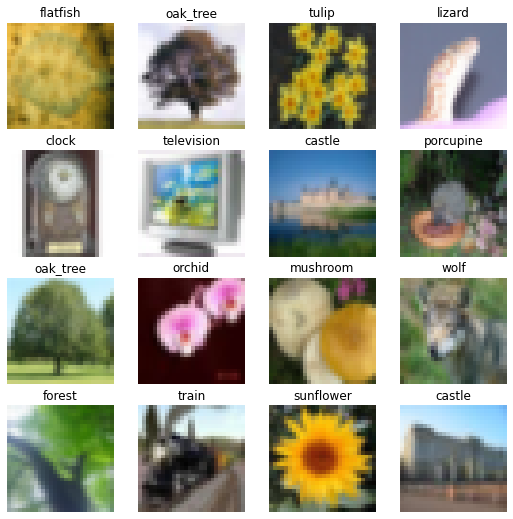

In [ ]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0))#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [82]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cpu" 

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [83]:
model_LENET_3 = LeNET(in_channels=3, out_channels=100).to(device)

In [84]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_LENET_3.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [85]:
#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_LENET_3, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_LENET_3,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 4.60513, Train acc: 1.00%


  2%|▏         | 1/50 [00:20<16:36, 20.34s/it]

Test Loss: 4.59456, Test acc: 1.53%
Epoch: 1 ----
Train Loss: 4.37737, Train acc: 3.78%


  4%|▍         | 2/50 [00:47<19:42, 24.64s/it]

Test Loss: 4.11174, Test acc: 6.70%
Epoch: 2 ----
Train Loss: 3.96500, Train acc: 9.09%


  6%|▌         | 3/50 [01:10<18:32, 23.67s/it]

Test Loss: 3.89378, Test acc: 11.46%
Epoch: 3 ----
Train Loss: 3.75451, Train acc: 12.61%


  8%|▊         | 4/50 [01:32<17:47, 23.20s/it]

Test Loss: 3.66988, Test acc: 14.71%
Epoch: 4 ----
Train Loss: 3.58634, Train acc: 15.61%


 10%|█         | 5/50 [01:54<16:56, 22.59s/it]

Test Loss: 3.67761, Test acc: 15.03%
Epoch: 5 ----
Train Loss: 3.47323, Train acc: 17.51%


 12%|█▏        | 6/50 [02:16<16:23, 22.35s/it]

Test Loss: 3.47696, Test acc: 17.47%
Epoch: 6 ----
Train Loss: 3.37700, Train acc: 19.11%


 14%|█▍        | 7/50 [02:38<16:02, 22.39s/it]

Test Loss: 3.40222, Test acc: 19.15%
Epoch: 7 ----
Train Loss: 3.29474, Train acc: 20.66%


 16%|█▌        | 8/50 [03:00<15:31, 22.19s/it]

Test Loss: 3.34887, Test acc: 19.85%
Epoch: 8 ----
Train Loss: 3.22195, Train acc: 21.95%


 18%|█▊        | 9/50 [03:21<14:57, 21.88s/it]

Test Loss: 3.34018, Test acc: 20.54%
Epoch: 9 ----
Train Loss: 3.15823, Train acc: 23.11%


 20%|██        | 10/50 [03:42<14:16, 21.42s/it]

Test Loss: 3.29801, Test acc: 21.32%
Epoch: 10 ----
Train Loss: 3.10171, Train acc: 24.30%


 22%|██▏       | 11/50 [04:02<13:41, 21.07s/it]

Test Loss: 3.35083, Test acc: 19.96%
Epoch: 11 ----
Train Loss: 3.05330, Train acc: 25.05%


 24%|██▍       | 12/50 [04:22<13:14, 20.90s/it]

Test Loss: 3.17514, Test acc: 23.43%
Epoch: 12 ----
Train Loss: 3.00837, Train acc: 25.77%


 26%|██▌       | 13/50 [04:44<12:57, 21.02s/it]

Test Loss: 3.24329, Test acc: 23.14%
Epoch: 13 ----
Train Loss: 2.96775, Train acc: 26.59%


 28%|██▊       | 14/50 [05:09<13:17, 22.16s/it]

Test Loss: 3.17597, Test acc: 23.77%
Epoch: 14 ----
Train Loss: 2.92241, Train acc: 27.57%


 30%|███       | 15/50 [05:32<13:03, 22.40s/it]

Test Loss: 3.14149, Test acc: 24.63%
Epoch: 15 ----
Train Loss: 2.88625, Train acc: 28.19%


 32%|███▏      | 16/50 [05:54<12:47, 22.57s/it]

Test Loss: 3.18067, Test acc: 24.08%
Epoch: 16 ----
Train Loss: 2.85324, Train acc: 28.88%


 34%|███▍      | 17/50 [06:17<12:27, 22.64s/it]

Test Loss: 3.13005, Test acc: 24.70%
Epoch: 17 ----
Train Loss: 2.81421, Train acc: 29.59%


 36%|███▌      | 18/50 [06:40<12:07, 22.74s/it]

Test Loss: 3.16597, Test acc: 24.22%
Epoch: 18 ----
Train Loss: 2.78229, Train acc: 30.16%


 38%|███▊      | 19/50 [07:03<11:47, 22.82s/it]

Test Loss: 3.26942, Test acc: 24.03%
Epoch: 19 ----
Train Loss: 2.75176, Train acc: 30.79%


 40%|████      | 20/50 [07:26<11:25, 22.85s/it]

Test Loss: 3.09943, Test acc: 25.98%
Epoch: 20 ----
Train Loss: 2.72462, Train acc: 31.51%


 42%|████▏     | 21/50 [07:49<11:03, 22.86s/it]

Test Loss: 3.15182, Test acc: 24.97%
Epoch: 21 ----
Train Loss: 2.69721, Train acc: 31.80%


 44%|████▍     | 22/50 [08:12<10:41, 22.89s/it]

Test Loss: 3.11030, Test acc: 26.19%
Epoch: 22 ----
Train Loss: 2.66728, Train acc: 32.58%


 46%|████▌     | 23/50 [08:35<10:16, 22.83s/it]

Test Loss: 3.09841, Test acc: 26.04%
Epoch: 23 ----
Train Loss: 2.63910, Train acc: 33.17%


 48%|████▊     | 24/50 [08:59<10:07, 23.38s/it]

Test Loss: 3.16362, Test acc: 25.92%
Epoch: 24 ----
Train Loss: 2.61634, Train acc: 33.63%


 50%|█████     | 25/50 [09:22<09:38, 23.13s/it]

Test Loss: 3.09450, Test acc: 26.56%
Epoch: 25 ----
Train Loss: 2.59201, Train acc: 33.90%


 52%|█████▏    | 26/50 [09:45<09:11, 22.98s/it]

Test Loss: 3.13973, Test acc: 25.46%
Epoch: 26 ----
Train Loss: 2.57006, Train acc: 34.59%


 54%|█████▍    | 27/50 [10:07<08:47, 22.95s/it]

Test Loss: 3.09756, Test acc: 26.89%
Epoch: 27 ----
Train Loss: 2.54602, Train acc: 34.97%


 56%|█████▌    | 28/50 [10:30<08:23, 22.89s/it]

Test Loss: 3.10216, Test acc: 25.77%
Epoch: 28 ----
Train Loss: 2.52411, Train acc: 35.59%


 58%|█████▊    | 29/50 [10:51<07:47, 22.26s/it]

Test Loss: 3.26460, Test acc: 25.10%
Epoch: 29 ----
Train Loss: 2.50591, Train acc: 35.87%


 60%|██████    | 30/50 [11:14<07:28, 22.42s/it]

Test Loss: 3.11003, Test acc: 26.38%
Epoch: 30 ----
Train Loss: 2.48442, Train acc: 36.41%


 62%|██████▏   | 31/50 [11:37<07:07, 22.51s/it]

Test Loss: 3.12906, Test acc: 26.67%
Epoch: 31 ----
Train Loss: 2.46457, Train acc: 36.69%


 64%|██████▍   | 32/50 [11:59<06:47, 22.64s/it]

Test Loss: 3.15484, Test acc: 25.97%
Epoch: 32 ----
Train Loss: 2.44942, Train acc: 36.97%


 66%|██████▌   | 33/50 [12:22<06:26, 22.74s/it]

Test Loss: 3.20428, Test acc: 24.93%
Epoch: 33 ----
Train Loss: 2.42848, Train acc: 37.68%


 68%|██████▊   | 34/50 [12:45<06:04, 22.80s/it]

Test Loss: 3.11827, Test acc: 26.70%
Epoch: 34 ----
Train Loss: 2.41715, Train acc: 37.62%


 70%|███████   | 35/50 [13:10<05:51, 23.46s/it]

Test Loss: 3.19896, Test acc: 26.29%
Epoch: 35 ----
Train Loss: 2.39741, Train acc: 38.04%


 72%|███████▏  | 36/50 [13:33<05:26, 23.31s/it]

Test Loss: 3.18050, Test acc: 26.36%
Epoch: 36 ----
Train Loss: 2.38062, Train acc: 38.28%


 74%|███████▍  | 37/50 [13:56<05:02, 23.23s/it]

Test Loss: 3.26466, Test acc: 26.13%
Epoch: 37 ----
Train Loss: 2.36974, Train acc: 38.47%


 76%|███████▌  | 38/50 [14:19<04:37, 23.10s/it]

Test Loss: 3.22566, Test acc: 25.60%
Epoch: 38 ----
Train Loss: 2.35382, Train acc: 38.60%


 78%|███████▊  | 39/50 [14:42<04:13, 23.03s/it]

Test Loss: 3.20400, Test acc: 25.05%
Epoch: 39 ----
Train Loss: 2.33934, Train acc: 39.00%


 80%|████████  | 40/50 [15:05<03:50, 23.05s/it]

Test Loss: 3.20566, Test acc: 25.96%
Epoch: 40 ----
Train Loss: 2.32501, Train acc: 39.44%


 82%|████████▏ | 41/50 [15:28<03:28, 23.11s/it]

Test Loss: 3.23992, Test acc: 25.14%
Epoch: 41 ----
Train Loss: 2.30924, Train acc: 39.77%


 84%|████████▍ | 42/50 [15:52<03:05, 23.14s/it]

Test Loss: 3.42678, Test acc: 24.86%
Epoch: 42 ----
Train Loss: 2.30484, Train acc: 40.13%


 86%|████████▌ | 43/50 [16:15<02:42, 23.16s/it]

Test Loss: 3.39216, Test acc: 25.59%
Epoch: 43 ----
Train Loss: 2.28743, Train acc: 40.18%


 88%|████████▊ | 44/50 [16:38<02:19, 23.23s/it]

Test Loss: 3.24514, Test acc: 25.41%
Epoch: 44 ----
Train Loss: 2.28042, Train acc: 40.31%


 90%|█████████ | 45/50 [17:03<01:59, 23.85s/it]

Test Loss: 3.29011, Test acc: 25.49%
Epoch: 45 ----
Train Loss: 2.26651, Train acc: 40.47%


 92%|█████████▏| 46/50 [17:27<01:34, 23.65s/it]

Test Loss: 3.44419, Test acc: 24.78%
Epoch: 46 ----
Train Loss: 2.25573, Train acc: 40.90%


 94%|█████████▍| 47/50 [17:50<01:10, 23.56s/it]

Test Loss: 3.42213, Test acc: 25.51%
Epoch: 47 ----
Train Loss: 2.24202, Train acc: 41.19%


 96%|█████████▌| 48/50 [18:13<00:46, 23.49s/it]

Test Loss: 3.30030, Test acc: 25.98%
Epoch: 48 ----
Train Loss: 2.23435, Train acc: 41.40%


 98%|█████████▊| 49/50 [18:36<00:23, 23.10s/it]

Test Loss: 3.35669, Test acc: 25.67%
Epoch: 49 ----
Train Loss: 2.22084, Train acc: 41.64%


100%|██████████| 50/50 [18:58<00:00, 22.77s/it]

Test Loss: 3.29118, Test acc: 26.27%
Train time on cpu : 1138.548 seconds


In [86]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "04_LENET_CIFAR100pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [87]:
#Saving the model
torch.save(obj=model_LENET_3.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/04_LENET_CIFAR100pth


In [88]:
#Loading the model
#Create a new instance of the model and update the parameters
model_LENET_CIFAR100 = LeNET(in_channels=3).to(device)
model_LENET_CIFAR100.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [89]:
#Get model results
model_LENET_CIFAR100_results = eval_model(
    model=model_LENET_CIFAR100,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_LENET_CIFAR100_results

100%|██████████| 313/313 [00:02<00:00, 110.95it/s]


{'model_name': 'LeNET',
 'model_loss': 3.291184902191162,
 'model_acc': 26.26797124600639}

In [99]:
list(model_LENET_MNIST_results.values())[0] = "LeNET_MNIST"
list(model_LENET_MNIST_results.values())[0]

'LeNET'

In [91]:
import pandas as pd
compare_results = pd.DataFrame([model_LENET_MNIST_results,
                                model_LENET_FashionMNIST_results,
                                model_LENET_CIFAR10_results,
                                model_LENET_CIFAR100_results])
compare_results

,model_name,model_loss,model_acc
0,LeNET,0.045953,99.021565
1,LeNET,0.364475,89.436901
2,LeNET,1.845477,57.248403
3,LeNET,3.291185,26.267971


In the chart below the models are as follows :

LeNET on MNIST Dataset

LeNET on FashionMNIST Dataset

LeNET on CIFAR 10 Dataset

LeNET on CIFAR 100 Dataset

Text(0, 0.5, 'Model')

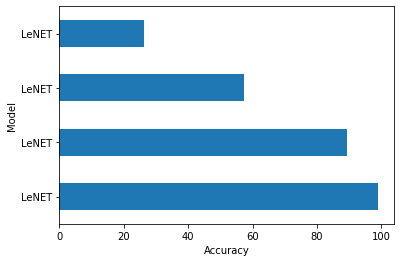

In [92]:
#Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy")
plt.ylabel("Model")